In [1]:
# Requirements: torch, numpy, matplotlib
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# -----------------------------
# 1) Dot-product attention (toy)
# -----------------------------

def dot_product_attention(Q, K, V, mask=None, dropout=None):
    """Compute scaled dot-product attention.
    Q: (batch, seq_q, d_k)
    K: (batch, seq_k, d_k)
    V: (batch, seq_k, d_v)
    mask: (batch, seq_q, seq_k) or None
    returns: (batch, seq_q, d_v), attention_weights
    """
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)  # (b, seq_q, seq_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))
    attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        attn = dropout(attn)
    output = torch.matmul(attn, V)
    return output, attn




In [3]:
# toy demo
print("--- Dot-product attention toy demo ---")
Q = torch.tensor([[[1.0, 0.0]]]) # (1,1,2)
K = torch.tensor([[[1.0, 0.0],[0.0,1.0]]]) # (1,2,2)
V = torch.tensor([[[10.0,0.0],[0.0,10.0]]]) # (1,2,2)
out, attn = dot_product_attention(Q, K, V)
print("Output:", out)
print("Attention weights:", attn)

--- Dot-product attention toy demo ---
Output: tensor([[[6.6976, 3.3024]]])
Attention weights: tensor([[[0.6698, 0.3302]]])


In [4]:
# change query and see effect
Q2 = torch.tensor([[[0.0, 1.0]]])
out2, attn2 = dot_product_attention(Q2, K, V)
print("Output (Q2):", out2)
print("Attention weights (Q2):", attn2)

Output (Q2): tensor([[[3.3024, 6.6976]]])
Attention weights (Q2): tensor([[[0.3302, 0.6698]]])



--- Positional Encoding visualization ---


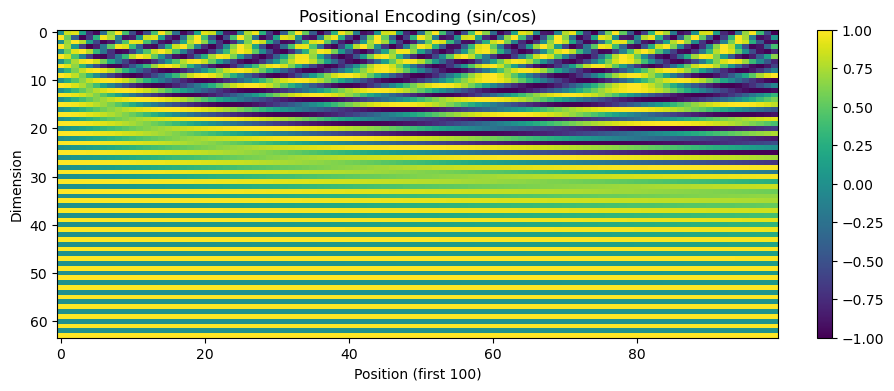

In [5]:
# -----------------------------
# 2) Positional Encoding
# -----------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # (1, max_len, d_model)
        self.register_buffer('pe', pe)


    def forward(self, x):
        # x: (batch, seq_len, d_model)
        x = x + self.pe[:, :x.size(1), :]
        return x


# visualize positional encoding
print('\n--- Positional Encoding visualization ---')
pe = PositionalEncoding(d_model=64, max_len=200)
sample = pe.pe[0].numpy() # (max_len, d_model)
plt.figure(figsize=(10,4))
plt.imshow(sample[:100].T, aspect='auto')
plt.xlabel('Position (first 100)')
plt.ylabel('Dimension')
plt.title('Positional Encoding (sin/cos)')
plt.colorbar(fraction=0.02)
plt.show()

In [ ]:
# -----------------------------
self.num_heads = num_heads
self.d_k = d_model // num_heads
self.q_linear = nn.Linear(d_model, d_model)
self.k_linear = nn.Linear(d_model, d_model)
self.v_linear = nn.Linear(d_model, d_model)
self.out_linear = nn.Linear(d_model, d_model)
self.dropout = nn.Dropout(dropout)


def split_heads(self, x):
# x: (batch, seq_len, d_model) -> (batch, num_heads, seq_len, d_k)
b, seq_len, _ = x.size()
x = x.view(b, seq_len, self.num_heads, self.d_k).transpose(1,2)
return x


def combine_heads(self, x):
# x: (batch, num_heads, seq_len, d_k) -> (batch, seq_len, d_model)
b, h, seq_len, d_k = x.size()
x = x.transpose(1,2).contiguous().view(b, seq_len, h * d_k)
return x


def forward(self, query, key, value, mask=None):
# query/key/value: (batch, seq_len, d_model)
Q = self.q_linear(query)
K = self.k_linear(key)
V = self.v_linear(value)
Qh = self.split_heads(Q)
Kh = self.split_heads(K)
Vh = self.split_heads(V)
# compute scaled dot-product for each head
# reshape to (batch*num_heads, seq_len, d_k) to reuse function
b, h, seq_q, d_k = Qh.size()
seq_k = Kh.size(2)
Qflat = Qh.reshape(b*h, seq_q, d_k)
Kflat = Kh.reshape(b*h, seq_k, d_k)
Vflat = Vh.reshape(b*h, seq_k, d_k)
scores = torch.matmul(Qflat, Kflat.transpose(-2,-1)) / math.sqrt(d_k)
if mask is not None:
# mask needs broadcasting to (b*h, seq_q, seq_k)
mask = mask.repeat_interleave(self.num_heads, dim=0)
scores = scores.masked_fill(mask==0, float('-inf'))
attn = F.softmax(scores, dim=-1)
attn = self.dropout(attn)
out_flat = torch.matmul(attn, Vflat) # (b*h, seq_q, d_k)
out = out_flat.view(b, h, seq_q, d_k)
out = self.combine_heads(out)
out = self.out_linear(out)
# For visualization, return average attention across heads in original shape (b, seq_q, seq_k)
attn_visual = attn.view(b, h, seq_q, seq_k).mean(dim=1)
return out, attn_visual

In [ ]:


# toy multihead demo
print('\n--- MultiHeadAttention toy demo ---')
d_model = 16
num_heads = 4
mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
# small sequence: batch=1, seq=5
x = torch.randn(1,5,d_model)
out_mha, attn_map = mha(x,x,x)
print('Output shape:', out_mha.shape)
print('Attention map shape:', attn_map.shape)
plt.figure(figsize=(6,4))
plt.imshow(attn_map[0].detach().numpy(), aspect='auto')
plt.colorbar()
plt.title('Average Attention across heads (toy)')
plt.xlabel('Key position')
plt.ylabel('Query position')
plt.show()

In [ ]:
# -----------------------------
# 4) Position-wise Feed-Forward + LayerNorm
# -----------------------------
class PositionwiseFFN(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
    super().__init__()
    self.net = nn.Sequential(
    nn.Linear(d_model, d_ff),
    nn.ReLU(),
    nn.Dropout(dropout),
    nn.Linear(d_ff, d_model)
    )
    def forward(self, x):
    return self.net(x)


print('\n--- FeedForward + LayerNorm demo ---')
ln = nn.LayerNorm(16)
ffn = PositionwiseFFN(d_model=16, d_ff=64)
inp = torch.randn(2,10,16)
residual = inp
out_ffn = ffn(inp)
out = ln(out_ffn + residual)
print('shape after FFN + Add & Norm:', out.shape)

In [ ]:


# -----------------------------
# 5) Small Transformer (torch.nn.Transformer) demo
# -----------------------------
print('\n--- Small nn.Transformer demo (shapes) ---')
# `nn.Transformer` expects shape (seq_len, batch, d_model)
src_seq_len = 7
tgt_seq_len = 9
batch = 2
d_model = 32
nhead = 4
src = torch.rand(src_seq_len, batch, d_model)
tgt = torch.rand(tgt_seq_len, batch, d_model)
transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=2, num_decoder_layers=2)
out = transformer(src, tgt) # (tgt_seq_len, batch, d_model)
print('Transformer output shape:', out.shape)

In [ ]:
# -----------------------------
# 6) Small seq2seq example (toy tokens -> embeddings)
# -----------------------------
print('\n--- Small seq2seq toy example (embedding -> transformer -> linear) ---')
vocab_size = 50
embed = nn.Embedding(vocab_size, d_model)
linear_out = nn.Linear(d_model, vocab_size)


# random token sequences
src_tokens = torch.randint(0, vocab_size, (src_seq_len, batch))
tgt_tokens = torch.randint(0, vocab_size, (tgt_seq_len, batch))


src_emb = embed(src_tokens)
tgt_emb = embed(tgt_tokens)


out = transformer(src_emb, tgt_emb)
logits = linear_out(out) # (tgt_seq_len, batch, vocab)
print('Logits shape:', logits.shape)


# show softmax for first position of first batch
probs = F.softmax(logits[:,0,:], dim=-1)
print('Sample probability distribution (first target timestep):\n', probs[0,:10].detach().numpy())


print('\nAll demo components ready. Modify d_model/seq_len to suit runtime constraints in Colab.')